In [10]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

import pickle
import joblib
from joblib import dump, load

from collections import Counter
from imblearn.over_sampling import SMOTE 

# Data Preprocessing

In [40]:
def file_name_encoding_init(file_names):
    le_filename = preprocessing.LabelEncoder()
    le_filename.fit(file_names)
    dump(le_filename, 'Task A Assets/Task_A_file_name_encoder.joblib') 

def label_encoding_init(labels):
    le_label = preprocessing.LabelEncoder()
    le_label.fit(labels)
    dump(le_label, 'Task A Assets/Task_A_label_encoder.joblib') 

def SMOTE_preprocessing(file_names, labels):
    le_filename = joblib.load('Task A Assets/Task_A_file_name_encoder.joblib')
    le_filename.fit(file_names)
    le_file_names = le_filename.transform(file_names).reshape(-1,1)
    print(le_file_names.shape)
    
    sm = SMOTE()
    SMOTE_file_names, SMOTE_labels = sm.fit_resample(le_file_names, labels)
    print("Distribution of image categories post-SMOTE:")
    print(Counter(list(SMOTE_labels)))
    
    SMOTE_file_names = le_filename.inverse_transform(SMOTE_file_names)

    return SMOTE_file_names, SMOTE_labels

def image_processing(file_names):
    dataset_tumor=[]
    for file_name in file_names:
        file=cv2.imread(data_path+"/image/"+file_name)
        file_resize=cv2.resize(file,(128,128))/255.
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    return tumor_data

def preprocessing_data(data_path, file, status):

    data=pd.read_csv(data_path+file)
    file_names=list(data['file_name'])
    data['label'] = data['label'].apply(lambda x: "no_tumor" if x == "no_tumor" else "tumor")
    labels=data['label'].values.reshape(-1,1)
    
    if status == 'training':
        
        print("Distribution of image categories:")
        print(Counter(list(data['label'])))
    
        file_name_encoding_init(file_names)
        label_encoding_init(labels)
        
        
        file_names, labels = SMOTE_preprocessing(file_names, labels)
        x_train,x_test,y_train,y_test = train_test_split(file_names,labels,test_size=0.2)
        
        x_train = image_processing(x_train)
        x_test = image_processing(x_test)

        le_label = joblib.load('Task A Assets/Task_A_label_encoder.joblib')
        
        y_train = le_label.transform(y_train)
        y_test = le_label.transform(y_test)

        x_train = x_train.reshape(x_train.shape[0],128*128*3)
        x_test = x_test.reshape(x_test.shape[0],128*128*3)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
        return x_train, x_test, y_train, y_test

    
    elif status == 'testing':
        le_label = joblib.load('Task A Assets/Task_A_label_encoder.joblib')
        y_test = le_label.transform(labels)
        x_test = image_processing(file_names) 
                              
        return x_test, y_test
    

def define_SVC():
    svc = svm.SVC()
    return svc

    
def train_SVC(x_train,y_train):
    model = define_SVC()
    model.fit(x_train, y_train)
    pickle.dump(model, open("Task A Assets/Task_A_SVM_Model", 'wb'))
    
    return model

def test_model(x_test, y_test):

    loaded_model = pickle.load(open("Task A Assets/Task_A_SVM_Model", 'rb'))
    y_pred_svm = loaded_model.predict(x_test)
    print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred_svm)))
    
    #text report showing the main classification metrics
    print(classification_report(y_test,y_pred_svm))
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap = 'Blues')
    plt.show()

## Data Preprocessing (Training)

In [38]:
data_path="dataset/"
file = "label.csv"

x_train, x_test, y_train, y_test = preprocessing_data(data_path, file, 'training')

Distribution of image categories:
Counter({'tumor': 2546, 'no_tumor': 454})
(3000, 1)
Distribution of image categories post-SMOTE:
Counter({'tumor': 2546, 'no_tumor': 2546})


C:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Training and Validation

In [39]:
model = train_SVC(x_train, y_train)

# Testing (using splitted sample data)

Accuracy on test set: 0.677134445534838
              precision    recall  f1-score   support

           0       0.79      0.46      0.59       499
           1       0.63      0.88      0.74       520

    accuracy                           0.68      1019
   macro avg       0.71      0.67      0.66      1019
weighted avg       0.71      0.68      0.66      1019



<Figure size 360x360 with 0 Axes>

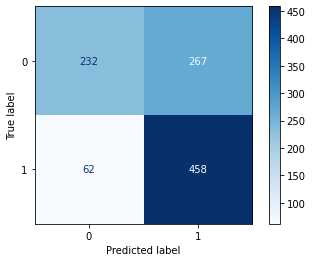

In [41]:
test_model(x_test,y_test)

# TO DO!!!

In [1]:
#add cross validation for svc
#add gridsearch
#tidy up functions